In [ ]:
!pip install pysptk pyworld librosa tqdm

In [ ]:
!wget http://festvox.org/cmu_arctic/packed/cmu_us_aew_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_ahw_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_aup_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_awb_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_axb_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_bdl_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_clb_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_eey_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_fem_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_gka_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_jmk_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_ksp_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_ljm_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_lnh_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_rms_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_rxr_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_slp_arctic.tar.bz2
!wget http://festvox.org/cmu_arctic/packed/cmu_us_slt_arctic.tar.bz2

In [ ]:
import os
os.listdir('.')

In [6]:
for f in os.listdir('.'):
  if '.bz2' in f :
    os.system('bunzip2 '+str(f))

In [7]:
for f in os.listdir('.'):
  if '.tar' in f :
    os.system('tar -xvf '+str(f))

In [8]:
for f in os.listdir('.'):
  if '.tar' in f :
    os.remove(f)

In [9]:
import shutil

In [10]:
folder_list = 'cmu_us_awb_arctic  cmu_us_clb_arctic  cmu_us_ksp_arctic  cmu_us_slt_arctic cmu_us_bdl_arctic  cmu_us_jmk_arctic  cmu_us_rms_arctic'.split()

In [ ]:
folder_list

In [12]:
os.mkdir('data')

In [ ]:
for folder in folder_list:
  shutil.move(folder,os.path.join('data',folder))

In [ ]:

DATA_ROOT = 'data'
!ls $DATA_ROOT

In [ ]:
!pip install nnmnkwii

In [ ]:
!pip install numpy==1.23.5

In [ ]:
pip install -U numba

In [5]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
# from nnmnkwii.preprocessing import DeltaAppender
from nnmnkwii.util import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [7]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = False

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

* collect_files : Collects .wav files. Also we split the files into train/test set.
* collect_features : Loads wav file and compute mel-cepstrum.

In [8]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [9]:
clb_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["clb"], max_files=max_files)
slt_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["slt"], max_files=max_files)

In [10]:
X = PaddedFileSourceDataset(clb_source, 1200).asarray()
Y = PaddedFileSourceDataset(slt_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(97, 1200, 25)
(97, 1200, 25)


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def plot_parallel(x,y):
  plt.figure(figsize=(16,7))
  plt.subplot(2,1,1)
  librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
  plt.colorbar()
  plt.subplot(2,1,2)
  librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
  plt.colorbar()

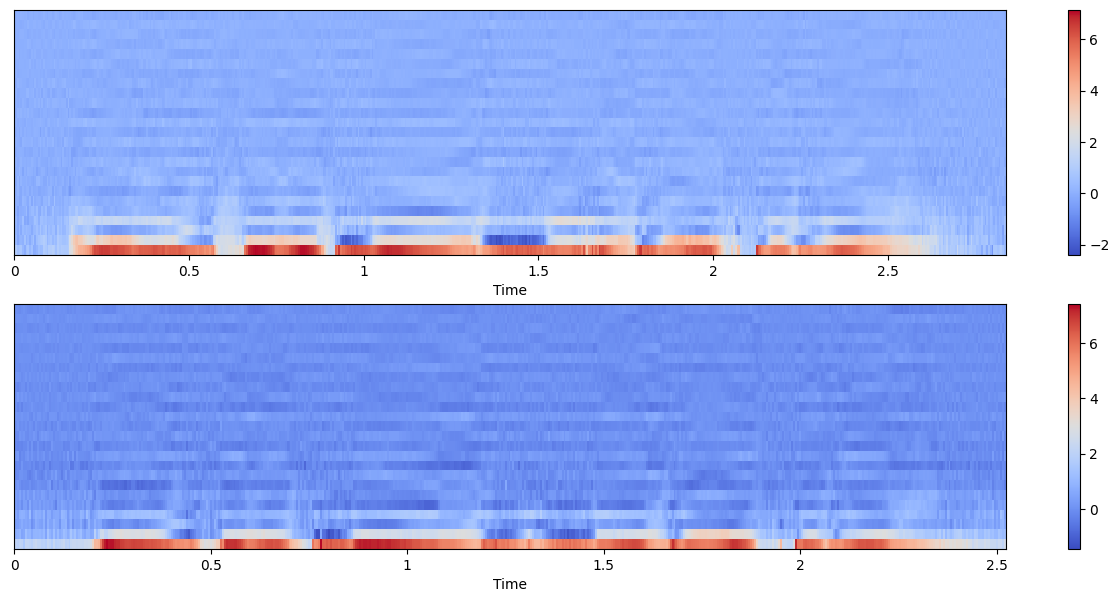

In [13]:
idx = 22 # any
plot_parallel(X[idx],Y[idx])

In [14]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

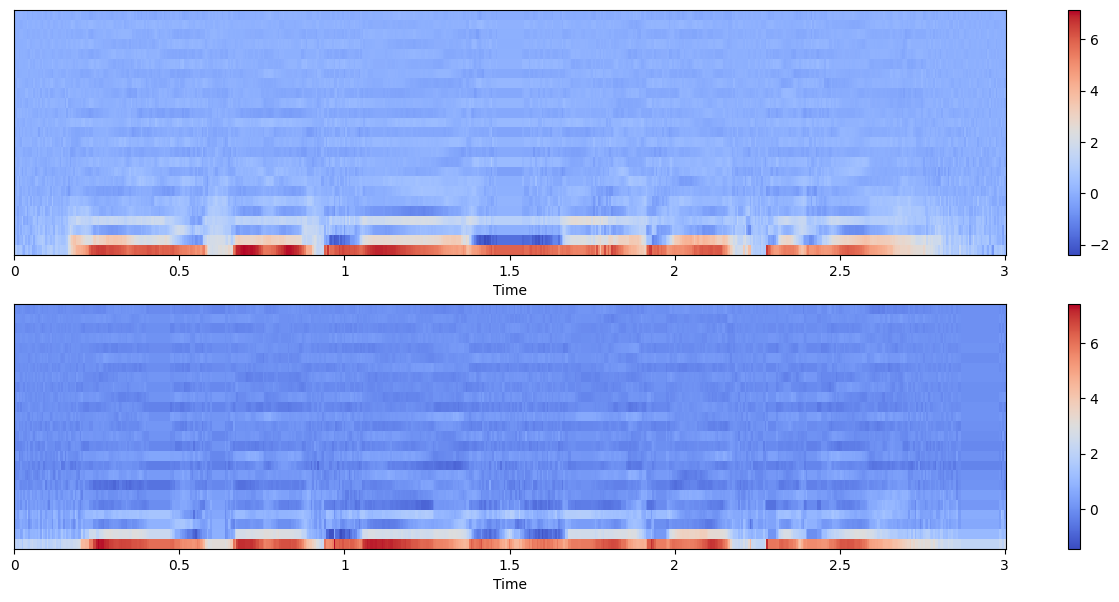

In [15]:

plot_parallel(X_aligned[idx],Y_aligned[idx])

0-th mel-cesptrum is a power coefficient by definition. Since we want to focus on spectral charactaristics, drop 1-st dimention from aligned features.

In [16]:
# Drop 1st (power) dimention
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [48]:
static_dim = X_aligned.shape[-1]


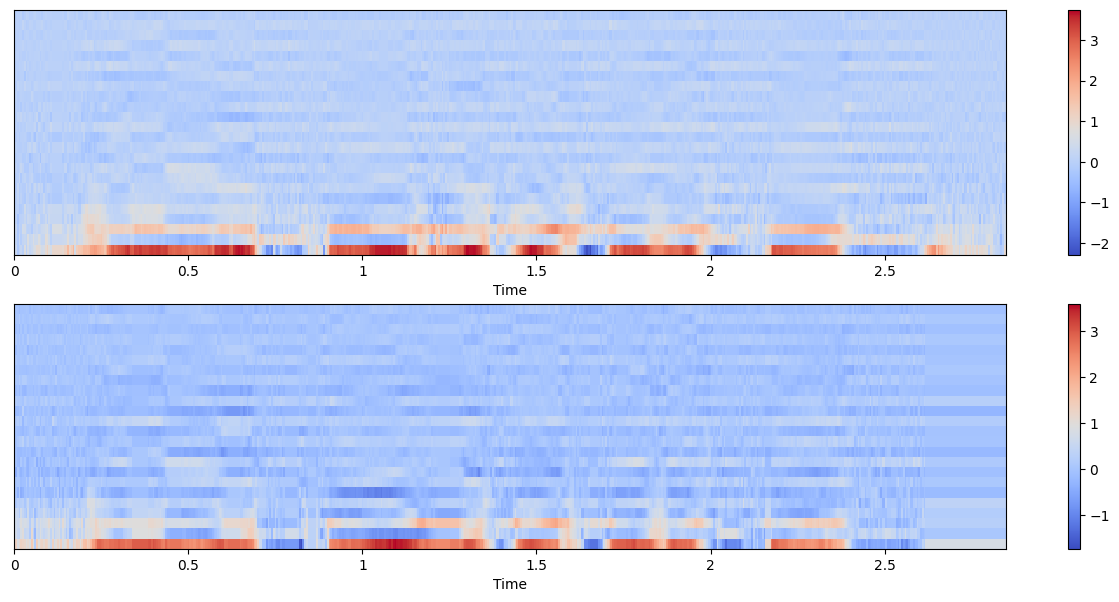

In [49]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [19]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(116400, 48)


Note that we padded zeros to data. Removes zeros frames to speed-up training.

In [ ]:
XY = remove_zeros_frames(XY)
print(XY.shape)

In [20]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
CPU times: user 18min 50s, sys: 12min 45s, total: 31min 36s
Wall time: 20min 20s


GaussianMixture(n_components=64, verbose=1)

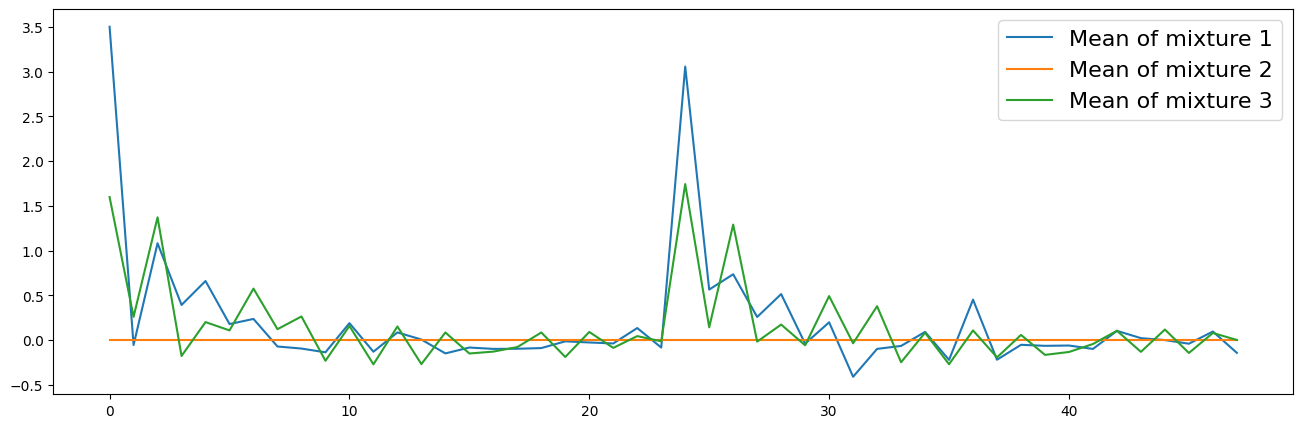

In [21]:

for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

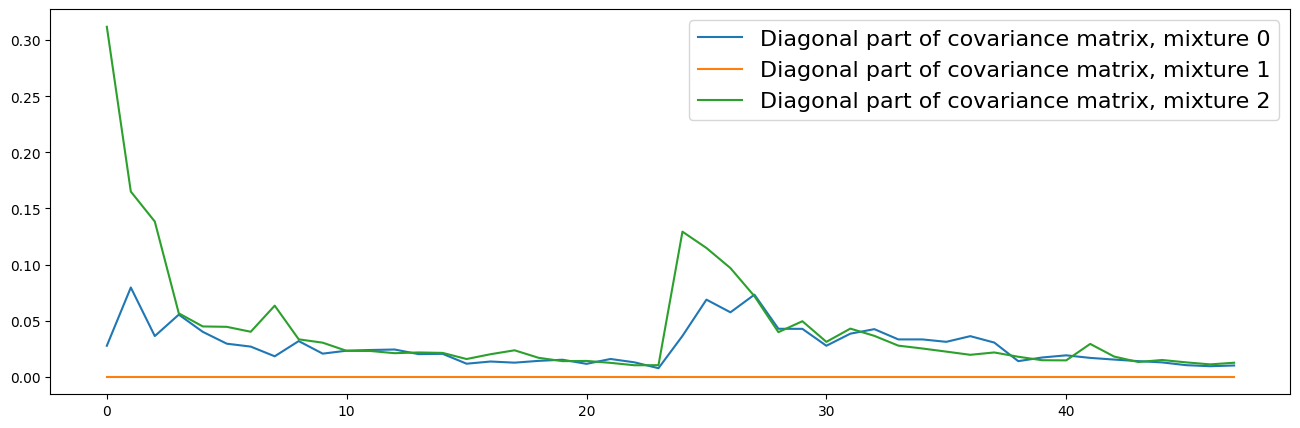

In [24]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [30]:
static_dim = X_aligned.shape[-1]

 Maximum Likelihood Parameter Generation (MLPG).

In [52]:
def test_one_utt(src_path,   diffvc=True):
    use_delta = False
    # GMM-based parameter generation is provided by the library in `baseline` module
    
    paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    
    fs, x = wavfile.read(src_path)
    print(fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    
    mc = paramgen.transform(mc)
    if  mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    # assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform

In [40]:

for i, (src_path, tgt_path) in enumerate(zip(clb_source.test_paths, slt_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path)
    
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)

    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    

1-th sample
Source: arctic_a0041.wav


Target: arctic_a0041.wav


w/o MLPG


w/ MLPG


2-th sample
Source: arctic_a0036.wav


Target: arctic_a0036.wav


w/o MLPG


w/ MLPG


3-th sample
Source: arctic_a0082.wav


Target: arctic_a0082.wav


w/o MLPG


w/ MLPG


In [ ]:

def vis_difference(x, y, which_dims=[0,2,3,6], T_max=None):
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)

    if T_max is not None and len(y) > T_max:
        y,y_hat1,y_hat2 = y[:T_max],y_hat1[:T_max],y_hat2[:T_max]

    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=2, label="w/o MLPG")
        
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")

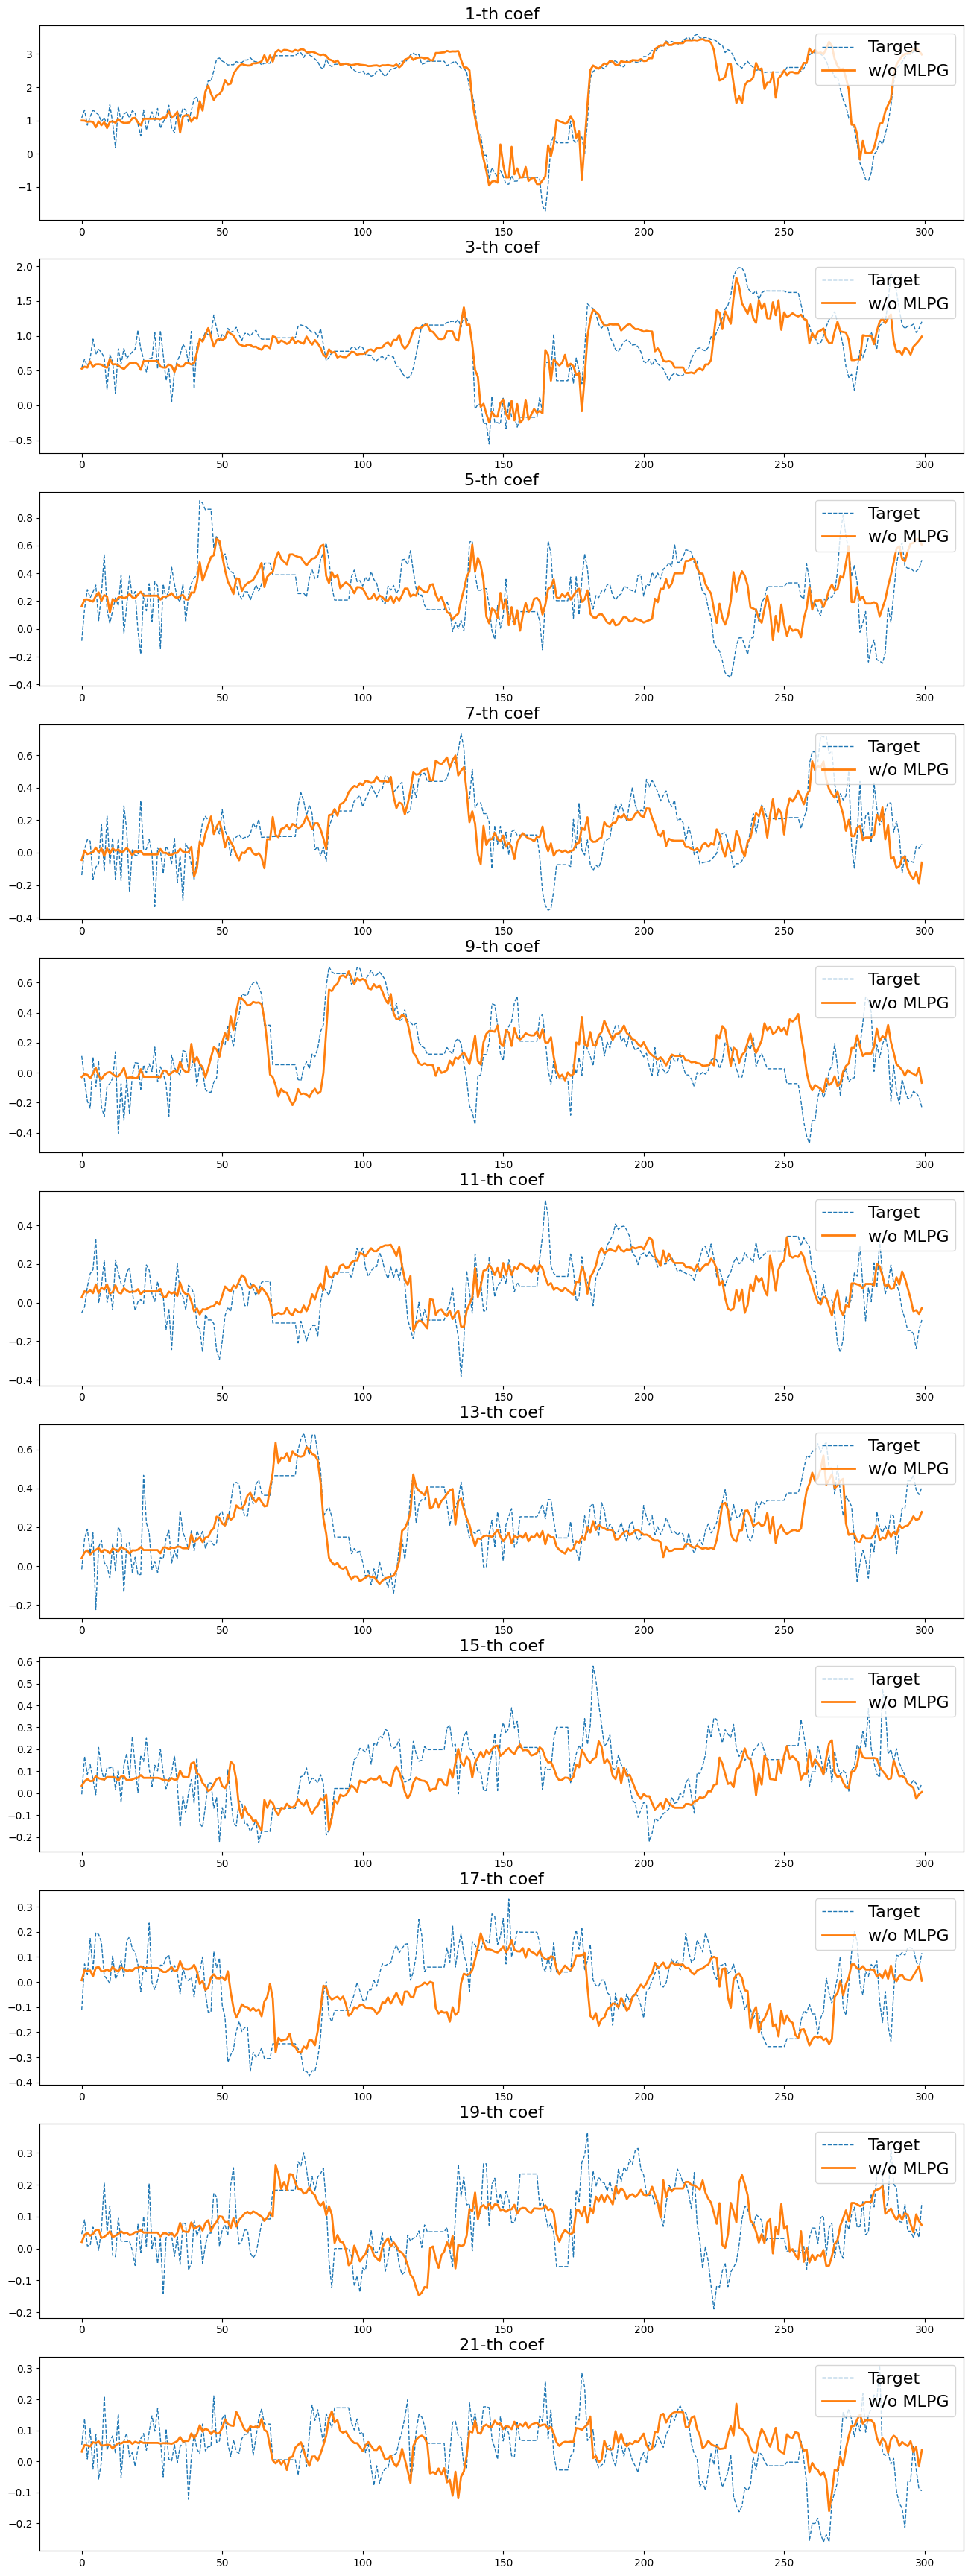

In [ ]:
idx = 0
which_dims = np.arange(0, static_dim-2, step=2)
vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)

In [54]:
f, src = wavfile.read('f2bjrop1.0.wav')
wo_MLPG = test_one_utt('f2bjrop1.0.wav')
IPython.display.display(Audio(wo_MLPG, rate=fs))

16000


In [56]:
f, src = wavfile.read('f2bjrop1.0.wav')
IPython.display.display(Audio(src, rate=fs))

In [66]:
import wave
import audioop
import os
def downsampleWav(src, dst, inrate=44100, outrate=16000, inchannels=2, outchannels=1):
    
    try:
        s_read = wave.open(src, 'r')
        s_write = wave.open(dst, 'w')
    except:
        print( 'Failed to open files!')
        return False

    n_frames = s_read.getnframes()
    data = s_read.readframes(n_frames)

    try:
        converted = audioop.ratecv(data, 2, inchannels, inrate, outrate, None)
        if outchannels == 1:
            converted = audioop.tomono(converted[0], 2, 1, 0)
    except:
        print ('Failed to downsample wav')
        return False

    try:
        s_write.setparams((outchannels, 2, outrate, 0, 'NONE', 'Uncompressed'))
        s_write.writeframes(converted)
    except:
        print ('Failed to write wav')
        return False

    try:
        s_read.close()
        s_write.close()
    except:
        print ('Failed to close wav files')
        return False

    return True

In [67]:
downsampleWav('test.wav', 'test2.wav', inrate=44100, outrate=16000, inchannels=2, outchannels=1)

True

In [68]:
f, src = wavfile.read('test2.wav')
print(f)
IPython.display.display(Audio(src, rate=fs))

16000


In [69]:
wo_MLPG = test_one_utt('test2.wav')
IPython.display.display(Audio(wo_MLPG, rate=fs))

16000
